In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# file_path =[]
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         file_path.append(os.path.join(dirname, filename))
# file_path[:10]

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[]

# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
import gc
gc.collect()

103

In [2]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split

#model building
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image, sequence
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
# from keras.layers.wrappers import Bidirectional
# from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
# Defining paths
INPUT_PATH = "/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/"
IMAGE_PATH = INPUT_PATH+'Images/'
CAPTIONS_FILE = INPUT_PATH+'captions.txt'
OUTPUT_IMAGE_PATH = "/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/output"

In [5]:
#Import the dataset and read the image into a seperate variable

images='/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8111


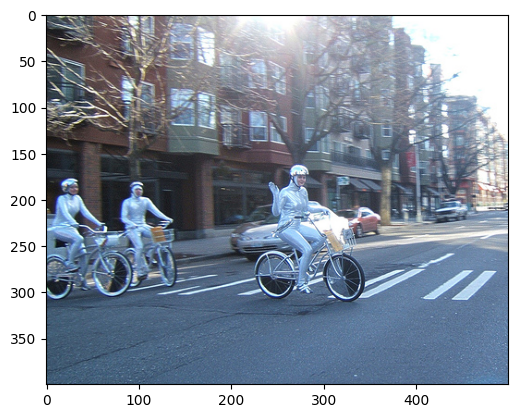

In [6]:

#Visualise both the images present in the dataset
plt.imshow(mpimg.imread(all_imgs[1]))

In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):

    with open(filename,'r') as f_in:
        text = list(filter(None, (line.rstrip() for line in f_in)))
    f_in.close()

    col=[]
    for line in text:
        col.append(line.split(",",maxsplit=1)) #Maxsplit 1 used to handle the captions with comma

    return col

doc = load_doc(CAPTIONS_FILE)
print(doc[:30])

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .'], ['1001773457_577c3a7d70.jpg', 'Two dogs on pavement moving toward each other .'], ['1002674143_1b742ab4b8.jpg', 'A little girl covere

In [8]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

pd.set_option('display.max_colwidth', None)  # Set max_colwidth to None

def get_thumbnail(path):
    #path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}" style="max-height:124px;">'


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
all_img_id = []
all_img_vector = []
annotations = []
image_visual = []

all_img_id = [i[0] for i in doc[1:]] #store all the image id here
all_img_vector= [IMAGE_PATH+i[0] for i in doc[1:]] #store all the image path here
annotations= [i[1] for i in doc[1:]] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733_0cb5439472.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [10]:
df_img = pd.DataFrame(zip([get_thumbnail(i) for i in df.Path.head().to_list()], df.Captions.head()), columns=['Images', 'Captions'])


,Images,Captions
0,,A child in a pink dress is climbing up a set of stairs in an entry way .
1,,A girl going into a wooden building .
2,,A little girl climbing into a wooden playhouse .
3,,A little girl climbing the stairs to her playhouse .
4,,A little girl in a pink dress going into a wooden cabin .

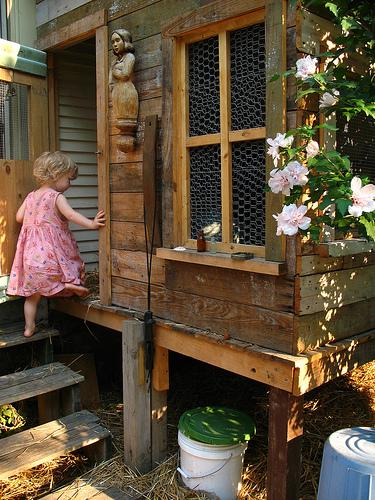
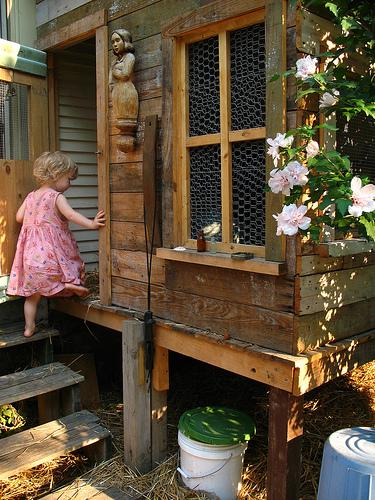
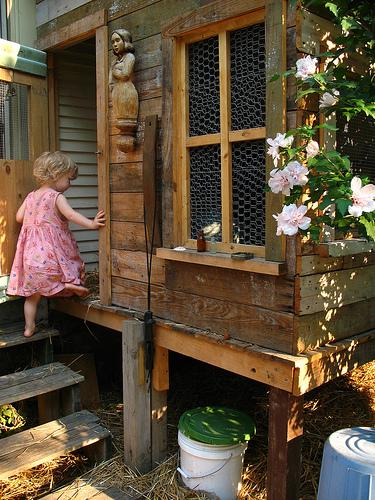
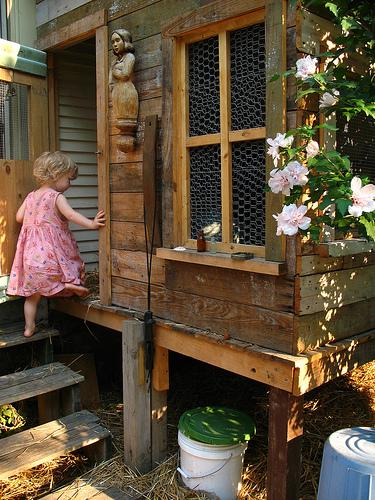
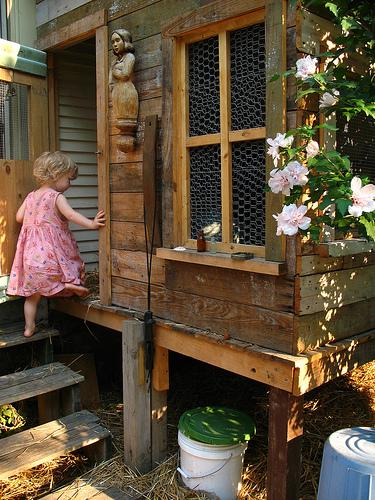

In [11]:
HTML(df_img.to_html(formatters={'Images': image_formatter}, escape=False))


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [13]:
#Create a list which contains all the captions
annotations = []

#add the <start> & <end> token to all those captions as well
for cap in df.Captions:
    cap='<start> '+ cap + ' <end>'
    annotations.append(cap)


#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [14]:
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


In [15]:
# get the vocabulary from the captions
vocabulary = []
for cap in df.Captions.values:
        vocabulary.extend(cap.split())

val_count = Counter(vocabulary)
print("Size of Vocab : ",len(set(vocabulary)))

Size of Vocab :  9862


In [16]:
val_count.most_common(30)


[('a', 40271),
 ('.', 34212),
 ('A', 21481),
 ('in', 18961),
 ('the', 15328),
 ('on', 10729),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7982),
 ('with', 7760),
 ('man', 6828),
 ('of', 6712),
 ('Two', 3962),
 ('white', 3875),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 ('woman', 3227),
 ('girl', 3217),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('The', 2920),
 ('at', 2904),
 ('water', 2774),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2442),
 ('young', 2431),
 ('."', 2365)]

In [17]:
stopwords.words('english')


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
#Visualise the top 30 occuring words in the captions

sorted_list = val_count.most_common(30)

def plot_word_count(wordCountList):
    word_list,wc_list = [],[]
    for word, count in wordCountList:
        word_list.append(word)
        wc_list.append(count)
    plt.figure(figsize=(20,6))
    sns.barplot(x = word_list, y = wc_list, orient='v').set_title('Top 30 occurinng words')


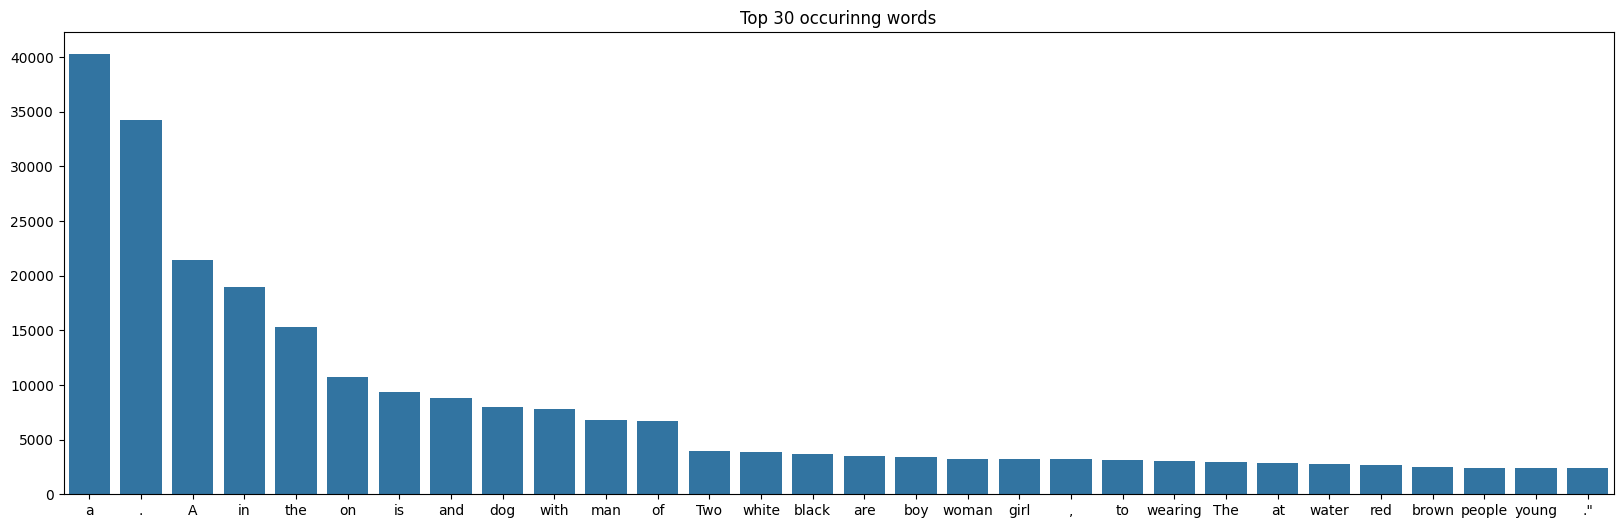

In [19]:
plot_word_count(sorted_list)


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [20]:
# create the tokenizer
top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


In [21]:
train_seqs[:5]


[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [22]:
annotations[:5]


['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [23]:
tokenizer.oov_token


'<unk>'

In [24]:
# Create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Encode training data sentences into sequences
train_seqs  = tokenizer.texts_to_sequences(annotations)

In [25]:
print(train_seqs[1])
print(annotations[1])

[3, 2, 20, 317, 65, 2, 197, 118, 4]
<start> A girl going into a wooden building . <end>


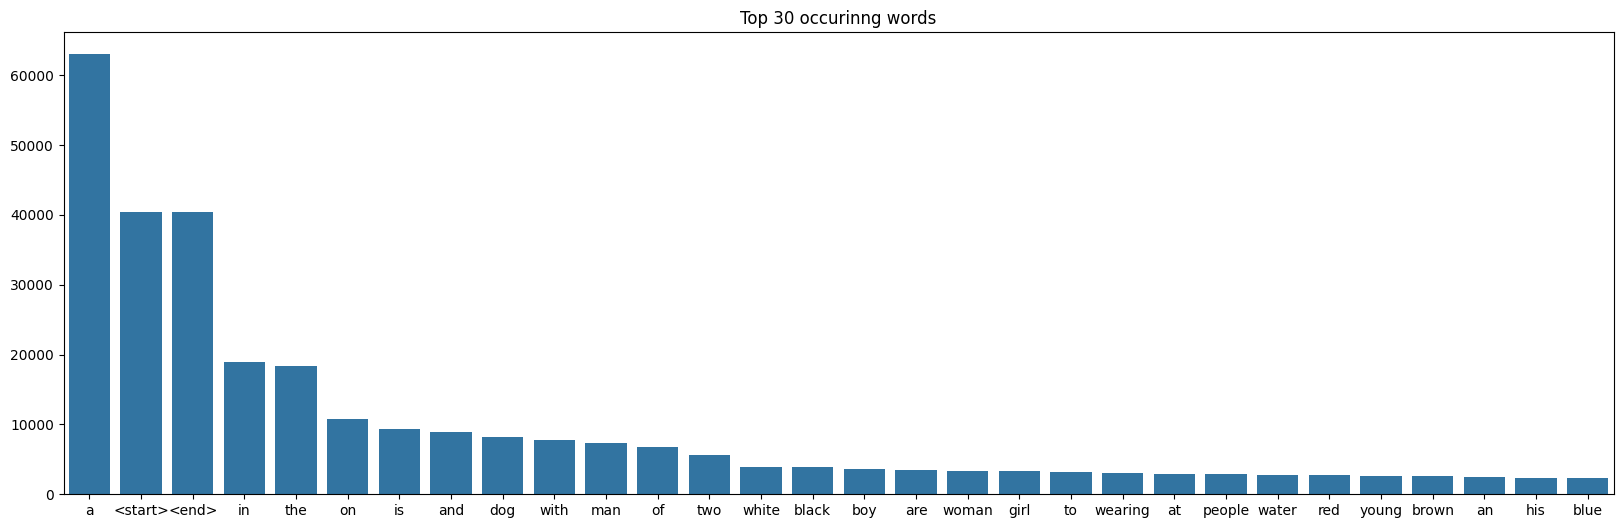

In [26]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_word_count(sort_word_by_count[:30])

In [27]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

max_length = max([len(t) for t in train_seqs])
print("The maximum length of a sentence in the annotation dataset is: " + str(max_length))

cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The maximum length of a sentence in the annotation dataset is: 39
The shape of Caption vector is :(40455, 39)


In [28]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

In [29]:
print(cap_vector[0])
print(annotations[0])

[  3   2  44   5   2  91 173   8 120  52   2 394  13 395   5  29   1 671
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [30]:
# write your code here for creating the function. This function should return images & their path
# We will use tensorflow to resize
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image, image_path

Path - /content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/1007129816_e794419615.jpg


Shape after resize : (299, 299, 3)


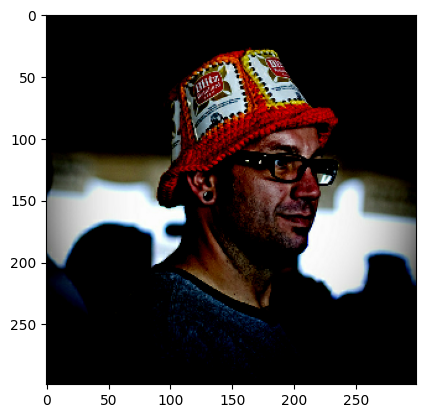

In [31]:
#Load function test
print("Path -",(all_img_vector[20]))
print("Shape after resize :", load_image(all_img_vector[20])[0].shape)
plt.imshow(load_image(all_img_vector[20])[0])

In [32]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
#Get unique images
all_img_vector_uniq = sorted(set(all_img_vector))

#Updating Batch Size to 64
BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_vector_uniq).map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

print("Unique number of Images:", len(all_img_vector_uniq))

Unique number of Images: 8091


In [33]:
image_dataset


<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [34]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [35]:
#Inception V3 Model
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# Getting the Pretrained Model Weights
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


In [36]:
image_features_extract_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [37]:
import gc
gc.collect()

19623

In [38]:
# code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_dict = {}
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        #image_dict[path_of_feature] =  bf.numpy()
        path_of_feature1 = os.path.basename(path_of_feature)
        path_of_feature2 = './'+path_of_feature1
        np.save(path_of_feature2, bf.numpy())

100%|██████████| 127/127 [04:21<00:00,  2.06s/it]


In [39]:
import gc
gc.collect()

0

In [40]:
len(image_dict)

0

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [41]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)


In [42]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


[  3   2  45 381 724   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> a person skiing downhill <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


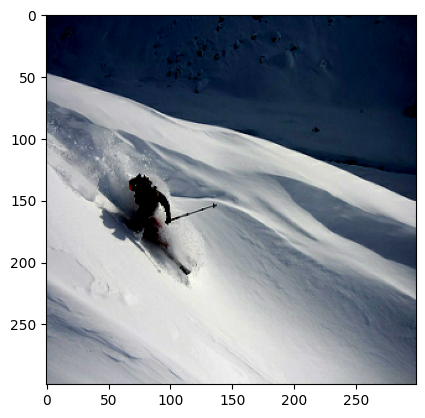

In [43]:
print(cap_test[4])
print(" ".join(tokenizer.index_word[i] for i in cap_test[4]))
plt.imshow(load_image(path_test[4])[0])

In [44]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
    #Memory utilization
    #img_tensor = image_dict[image.decode('utf-8')]
    img_name_temp = os.path.basename(image.numpy().decode('utf-8'))
    img_name_ip = './'+img_name_temp
    img_tensor = np.load(img_name_ip+'.npy')
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [45]:

# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def data_generator(image,caption, batch_size=32, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    #dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [46]:
train_dataset=data_generator(path_train,cap_train,64)
test_dataset=data_generator(path_test,cap_test,64)

In [47]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [48]:
BATCH_SIZE = 32
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

In [49]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features)
        features = tf.nn.relu(features)

        return features

In [50]:
encoder=Encoder(embedding_dim)

### Attention model

In [51]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)


        return context_vector, attention_weights

### Decoder

In [52]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [53]:
decoder=Decoder(embedding_dim, units, vocab_size)


In [54]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [55]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [56]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [57]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [59]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [60]:
print(tf.__version__)


2.15.0


* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [61]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            #predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            predicted_id = tf.argmax(predictions,1)
            # Not using teacher forcing since test dataset
            #dec_input = tf.expand_dims([predicted_id]* target.shape[0], 1)
            #dec_input = tf.expand_dims(target[:, i], 1)
            dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [62]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss

In [63]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 13.1 MiB
                            _9: 13.1 MiB
                    cap_vector:  6.0 MiB
                           _28:  6.0 MiB
                     cap_train:  4.8 MiB
                    vocabulary:  3.9 MiB
                      cap_test:  1.2 MiB
                           doc: 342.8 KiB
                    all_img_id: 342.8 KiB
                all_img_vector: 342.8 KiB
                   annotations: 342.8 KiB
                    train_seqs: 342.8 KiB
                  all_img_path: 316.1 KiB
                     val_count: 288.1 KiB
                    word_index: 288.1 KiB
                    index_word: 288.1 KiB
                    path_train: 270.8 KiB
            sort_word_by_count: 66.4 KiB
                      all_imgs: 65.6 KiB
                     path_test: 65.6 KiB


In [64]:
del df
del cap_vector
gc.collect()

22

In [65]:
import psutil
process = psutil.Process(os.getpid())
process.memory_info()

pmem(rss=2829422592, vms=20948406272, shared=1158168576, text=2818048, lib=0, data=2382336000, dirty=0)

In [66]:
tf.executing_eagerly()


True

In [67]:
#Model Training
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            #print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.636, & test loss is 0.942
Time taken for 1 epoch 296.8921263217926 sec

Test loss has been reduced from 100.000 to 0.942


 10%|█         | 2/20 [07:40<1:05:33, 218.52s/it]

For epoch: 2, the train loss is 0.494, & test loss is 0.952
Time taken for 1 epoch 163.35102009773254 sec



 15%|█▌        | 3/20 [10:43<57:14, 202.06s/it]  

For epoch: 3, the train loss is 0.448, & test loss is 0.965
Time taken for 1 epoch 182.44055914878845 sec



 20%|██        | 4/20 [13:55<52:52, 198.28s/it]

For epoch: 4, the train loss is 0.416, & test loss is 0.958
Time taken for 1 epoch 192.475195646286 sec



 25%|██▌       | 5/20 [17:13<49:34, 198.27s/it]

For epoch: 5, the train loss is 0.390, & test loss is 0.978
Time taken for 1 epoch 198.22743773460388 sec



 30%|███       | 6/20 [20:28<45:58, 197.04s/it]

For epoch: 6, the train loss is 0.367, & test loss is 0.980
Time taken for 1 epoch 194.64031338691711 sec



 35%|███▌      | 7/20 [23:58<43:37, 201.35s/it]

For epoch: 7, the train loss is 0.347, & test loss is 1.000
Time taken for 1 epoch 210.1827745437622 sec



 40%|████      | 8/20 [27:12<39:47, 198.95s/it]

For epoch: 8, the train loss is 0.328, & test loss is 1.027
Time taken for 1 epoch 193.77568364143372 sec



 45%|████▌     | 9/20 [30:21<35:54, 195.83s/it]

For epoch: 9, the train loss is 0.310, & test loss is 1.061
Time taken for 1 epoch 188.94586968421936 sec



 50%|█████     | 10/20 [33:42<32:54, 197.44s/it]

For epoch: 10, the train loss is 0.293, & test loss is 1.072
Time taken for 1 epoch 201.0337269306183 sec



 55%|█████▌    | 11/20 [36:59<29:34, 197.22s/it]

For epoch: 11, the train loss is 0.277, & test loss is 1.111
Time taken for 1 epoch 196.68552780151367 sec



 60%|██████    | 12/20 [40:18<26:22, 197.82s/it]

For epoch: 12, the train loss is 0.263, & test loss is 1.156
Time taken for 1 epoch 199.14971208572388 sec



 65%|██████▌   | 13/20 [43:30<22:51, 195.93s/it]

For epoch: 13, the train loss is 0.250, & test loss is 1.176
Time taken for 1 epoch 191.56082701683044 sec



 70%|███████   | 14/20 [46:40<19:25, 194.31s/it]

For epoch: 14, the train loss is 0.237, & test loss is 1.218
Time taken for 1 epoch 190.539897441864 sec



 75%|███████▌  | 15/20 [50:01<16:20, 196.18s/it]

For epoch: 15, the train loss is 0.226, & test loss is 1.239
Time taken for 1 epoch 200.46777176856995 sec



 80%|████████  | 16/20 [53:21<13:09, 197.43s/it]

For epoch: 16, the train loss is 0.215, & test loss is 1.292
Time taken for 1 epoch 200.312926530838 sec



 85%|████████▌ | 17/20 [56:30<09:44, 194.97s/it]

For epoch: 17, the train loss is 0.205, & test loss is 1.332
Time taken for 1 epoch 189.2266025543213 sec



 90%|█████████ | 18/20 [59:41<06:27, 193.80s/it]

For epoch: 18, the train loss is 0.196, & test loss is 1.362
Time taken for 1 epoch 191.05159735679626 sec



 95%|█████████▌| 19/20 [1:02:51<03:12, 192.58s/it]

For epoch: 19, the train loss is 0.187, & test loss is 1.418
Time taken for 1 epoch 189.71692514419556 sec



100%|██████████| 20/20 [1:06:03<00:00, 198.20s/it]

For epoch: 20, the train loss is 0.180, & test loss is 1.446
Time taken for 1 epoch 192.31152033805847 sec



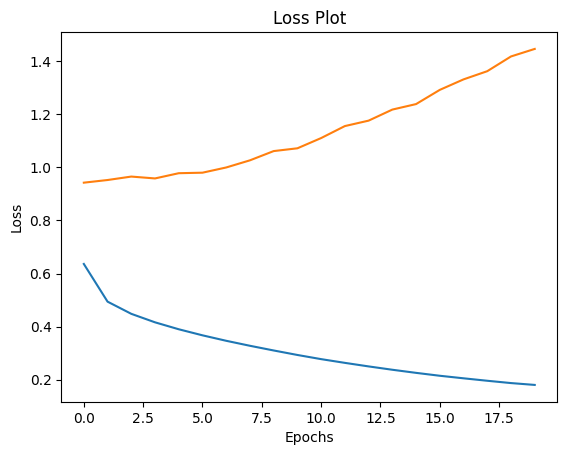

In [68]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [69]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    print("dec_input Shape", dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print("Predicted id", predicted_id)
        #print("result", tokenizer.index_word[predicted_id])

        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [70]:
# Using Beam Search Evaluation
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [71]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [72]:
from nltk.translate.bleu_score import sentence_bleu

In [73]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [74]:
from nltk.translate.bleu_score import sentence_bleu
def Testing_Model(img_test):
    #Testing on test image
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    # test_image = './images/413231421_43833a11f5.jpg'
    # real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption      :', real_caption)
    print ('Prediction Caption:', pred_caption)
    print ('')
    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")
    plot_attmap(result, attention_plot, test_image)

    # Image.open(test_image)
    return test_image, pred_caption



In [75]:
from PIL import Image
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    print(test_image)
    #real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    #plot_attmap(result, attention_plot, test_image)
    #plt.imshow(load_image(test_image)[0])

    im = Image.open(openImg)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))

#    newsize = (200, 200)
    #openImg = openImg.resize(200,200)
    #return Image.open(openImg).resize(newsize)
    return im


/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/2778290592_1910bb0431.jpg
dec_input Shape (1, 1)
Prediction Caption: a white dog running on a field is running in the mud

500 333


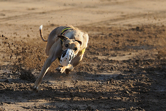

In [82]:
Prediction_Unknown_data(path_test[111])


/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/270263570_3160f360d3.jpg
dec_input Shape (1, 1)
Prediction Caption: two brown dogs playing in a rough manner

500 461


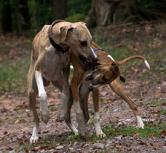

In [77]:
Prediction_Unknown_data(path_test[1])


/content/drive/MyDrive/EyeforBlind/Eye_for_bling_dataset/Images/3283897411_af9d0b497d.jpg
dec_input Shape (1, 1)
Prediction Caption: a little boy holds flaming object

333 500


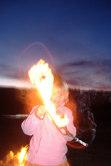

In [83]:
Prediction_Unknown_data(path_test[250])


dec_input Shape (1, 1)
Real Caption      : several dogs together in a winter setting
Prediction Caption: three racing dogs are playing in harness running in the snow


BELU score: 
Individual 1-gram: 18.181818181818183
Individual 2-gram: 2.2250738585072627e-306
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


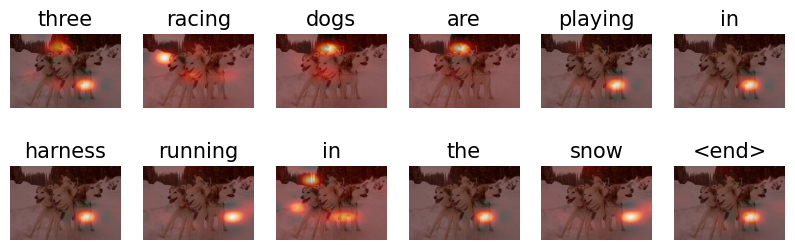

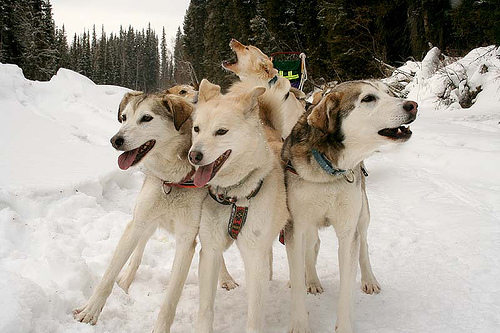

In [88]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

dec_input Shape (1, 1)
Real Caption      : a dog runs into an autumn forest with an orange line attached
Prediction Caption: a black and white dog leaps through the tall grass


BELU score: 
Individual 1-gram: 16.374615061559638
Individual 2-gram: 1.8217363958297825e-306
Individual 3-gram: 1.8217363958297825e-306
Individual 4-gram: 1.8217363958297825e-306


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

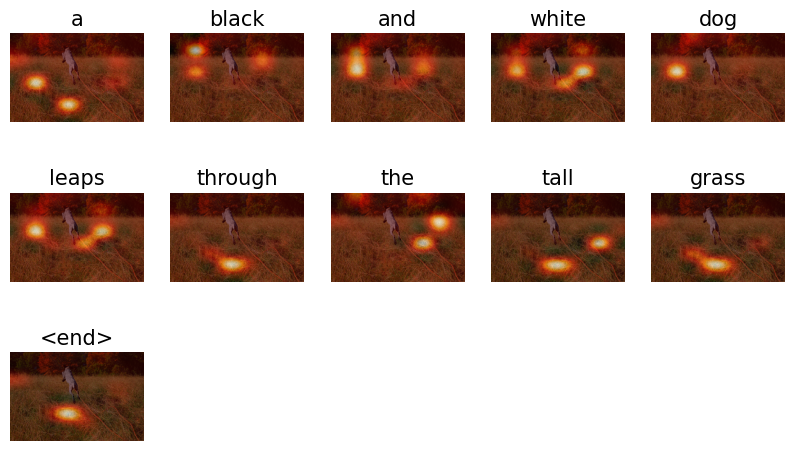

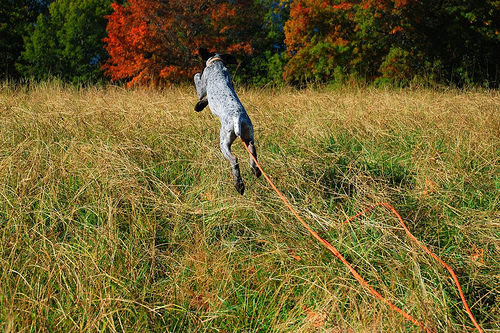

In [102]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

In [103]:
beam_caption=beam_evaluate(test_image)
print(beam_caption)

a black and white and and white dog in a black and white and and white dog in a black and white and and white dog in a black and white and and white dog in a black


In [104]:
pip install gTTS


In [105]:
# Libraries to convert text into audio
from gtts import gTTS
from IPython import display

In [106]:
#Caption to audio conversion
soundFile = 'pred_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))